# Time series classification


The data model for the example is:

...

In [1]:
import math
import matplotlib.pyplot as plt

# deep learning libraries
import torch
import torch.nn as nn
from torchctrnn import ODERNNCell,ODELSTMCell

In [2]:
def get_data(n_trajectories=128,n_samples = 30):
    """
    Simple time series classification task.
    The data generated is `n_trajectories` of irregularly sampled time series, each associated with a binary classification.
    The classification problem is whether a sine waves have a frequency less than 1. 
    """
    
    ts = 10*torch.rand(n_trajectories,n_samples).sort(dim=1)[0]
    freq = 1.0 + 0.1*torch.randn(n_trajectories)
    y = torch.zeros(n_trajectories)
    y[freq < 1.0] = 1.0

    X = torch.zeros(n_trajectories,n_samples)
    for j in range(n_trajectories):
        X[j] = torch.sin(freq[j]*ts[j])

    return X,y,ts

In [3]:
# training data
X,y,t = get_data(n_trajectories=256)

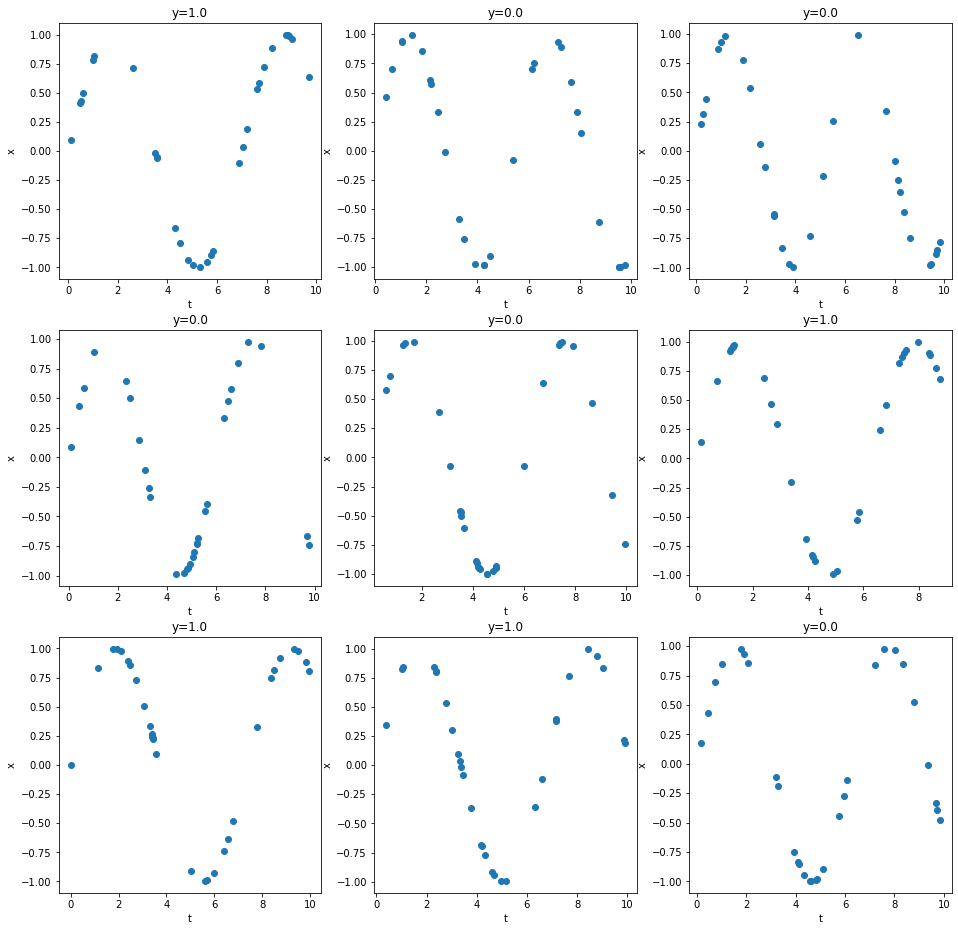

In [4]:
# example plots
n_plot = 3
fig, ax = plt.subplots(n_plot,n_plot,figsize=(16,16))
k = 0
for i in range(n_plot):
    for j in range(n_plot):
        ax[i,j].scatter(t[k],X[k])
        ax[i,j].set_title('y={}'.format(y[k].item()))
        ax[i,j].set_xlabel('t')
        ax[i,j].set_ylabel('x')
        k += 1
plt.show()

## Using an ODE-RNN for the task

The cell below sets up our networks.

ODERNN works as ...

In [5]:
class ODENet(nn.Module):
    """"
    Subnetwork
    This neural network defines the vector space
    Time dependent
    """

    def __init__(self,hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.net = nn.Sequential(
            nn.Linear(1+hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size),
        )

    def forward(self,input, t, dt, hidden):
        z = torch.cat((t,hidden),1)
        return self.net(z)

class ODERNNModel(nn.Module):
    """
    Full network
    """

    def __init__(self,ODENet,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.odernn = ODERNNCell(ODENet,input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, output_size),
            nn.Sigmoid(),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            times_j = times[:,j,:]
            h = self.odernn(xj,h,times_j)
            output[:,j,:] = self.decode(h)
        return output[:,J-1,:]

In [6]:
x_size = 1  # number of input features
hidden_size = 4
output_size = 1

odenet = ODENet(hidden_size)
odernn = ODERNNModel(odenet,x_size,hidden_size,output_size)

optimizer = torch.optim.Adam(odernn.parameters())

In [7]:
# the time data needs to be (start,stop)
# the last stop time could be set as 10 
# but we'll just drop the final X for simplicity
nt = t.shape[1]
time_gaps = torch.cat((t[:,0:(nt-1)].unsqueeze(2),t[:,1:].unsqueeze(2)),2)
print(time_gaps.shape)
X = X[:,0:(nt-1)]

torch.Size([256, 29, 2])


In [8]:
num_epochs = 20
train_dataset = torch.utils.data.TensorDataset(X.unsqueeze(2),y,time_gaps)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        x_batch,y_batch,t_batch = batch
        y_pred = odernn(t_batch,x_batch).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

Epoch: 0   Training loss: 0.6441477537155151
Epoch: 1   Training loss: 0.574001133441925
Epoch: 2   Training loss: 0.49705255031585693
Epoch: 3   Training loss: 0.4296635091304779
Epoch: 4   Training loss: 0.3734288811683655
Epoch: 5   Training loss: 0.3238682448863983
Epoch: 6   Training loss: 0.2869364321231842
Epoch: 7   Training loss: 0.2605542838573456
Epoch: 8   Training loss: 0.2427881956100464
Epoch: 9   Training loss: 0.23077163100242615
Epoch: 10   Training loss: 0.22227035462856293
Epoch: 11   Training loss: 0.21604692935943604
Epoch: 12   Training loss: 0.21139205992221832
Epoch: 13   Training loss: 0.20797239243984222
Epoch: 14   Training loss: 0.20553997159004211
Epoch: 15   Training loss: 0.20350800454616547
Epoch: 16   Training loss: 0.20111426711082458
Epoch: 17   Training loss: 0.1979469507932663
Epoch: 18   Training loss: 0.19388431310653687
Epoch: 19   Training loss: 0.18904322385787964


In [9]:
X_test,y_test,t_test = get_data()
t_gaps_test = torch.cat((t_test[:,0:(nt-1)].unsqueeze(2),t_test[:,1:].unsqueeze(2)),2)
X_test = X_test[:,0:(nt-1)].unsqueeze(2)
with torch.no_grad():
    y_pred = odernn(t_gaps_test,X_test).squeeze(-1)
y_pred_binary = (y_pred > 0.5).to(y_test.dtype)
prediction_matches = (y_pred_binary == y_test).to(y_test.dtype)
proportion_correct = prediction_matches.sum() / y_test.size(0)
print('Test Accuracy: {}'.format(proportion_correct))
print('Positive class: {}'.format(torch.sum(y_test)/y_test.shape[0]))

Test Accuracy: 0.921875
Positive class: 0.46875


## Using an ODE-LSTM for the task

Train with an LSTM

In [10]:
class ODELSTMModel(nn.Module):
    """
    Full network
    """

    def __init__(self,ODENet,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.odernn = ODELSTMCell(ODENet,input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, output_size),
            nn.Sigmoid(),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        c = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            times_j = times[:,j,:]
            h,c = self.odernn(xj,(h,c),times_j)
            output[:,j,:] = self.decode(h)
        return output[:,J-1,:]

In [11]:
# keep hidden size the same as the ODERNN model
odenet = ODENet(hidden_size)
odelstm = ODELSTMModel(odenet,x_size,hidden_size,output_size)

optimizer = torch.optim.Adam(odelstm.parameters())

In [12]:
for epoch in range(num_epochs):
    for batch in train_dataloader:
        x_batch,y_batch,t_batch = batch
        y_pred = odelstm(t_batch,x_batch).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

Epoch: 0   Training loss: 0.6838003993034363
Epoch: 1   Training loss: 0.6746290922164917
Epoch: 2   Training loss: 0.665937602519989
Epoch: 3   Training loss: 0.6554986834526062
Epoch: 4   Training loss: 0.6405116319656372
Epoch: 5   Training loss: 0.6170482635498047
Epoch: 6   Training loss: 0.5807449817657471
Epoch: 7   Training loss: 0.5326403975486755
Epoch: 8   Training loss: 0.4771760106086731
Epoch: 9   Training loss: 0.4183412492275238
Epoch: 10   Training loss: 0.35922372341156006
Epoch: 11   Training loss: 0.31182366609573364
Epoch: 12   Training loss: 0.2730042636394501
Epoch: 13   Training loss: 0.24714726209640503
Epoch: 14   Training loss: 0.2281603068113327
Epoch: 15   Training loss: 0.21669556200504303
Epoch: 16   Training loss: 0.20907458662986755
Epoch: 17   Training loss: 0.20500485599040985
Epoch: 18   Training loss: 0.2030680924654007
Epoch: 19   Training loss: 0.20271183550357819


In [13]:
with torch.no_grad():
    y_pred = odelstm(t_gaps_test,X_test).squeeze(-1)
y_pred_binary = (y_pred > 0.5).to(y_test.dtype)
prediction_matches = (y_pred_binary == y_test).to(y_test.dtype)
proportion_correct = prediction_matches.sum() / y_test.size(0)
print('Test Accuracy: {}'.format(proportion_correct))
print('Positive class: {}'.format(torch.sum(y_test)/y_test.shape[0]))

Test Accuracy: 0.90625
Positive class: 0.46875
